In [1]:
!nvidia-smi

Sat Jan 14 16:24:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:65:01.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.linalg import block_diag
from typing import List
from tqdm.notebook import tqdm
import numpy as np
from datasets import load_dataset
from promptsource.templates import DatasetTemplates
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import logging
import sys
import warnings
warnings.filterwarnings("ignore")

In [4]:
# For the classification task, in a Seq2Seq model like GLM, we need to calculate the conditional probability of choices for the given context.
# Remember to refer to code example (https://github.com/THUDM/GLM#classification) in GLM's repo.

# The `cond_log_prob` could be used for both multiple-choice problem (i.e., classification) or text generation (i.e., summurization).
def cond_log_prob_single_sample(context, choices):
    """
    Compute conditonal probability for one or more continuation/infilling options, single-sample only.
    General solution to all classification/multiple-choice tasks.
    :param context: prompted inputs. For example, "One plus one equals two, is it correct? Answer: [MASK]"
    :param choices: classification labels or choices. For example, ["No", "Yes"]
    """
    context_id = tokenizer(context)['input_ids']
    probs = []
    for choice in choices:
        choice_id = tokenizer(' ' + choice)['input_ids'][1:-1]  # Feature of SentencePiece tokenizer
        input_ids = torch.tensor(context_id + [tokenizer.sop_token_id] + choice_id[:-1], dtype=torch.long)
        attention_mask = torch.tril(torch.ones(len(input_ids), len(input_ids), dtype=torch.long))
        attention_mask[:len(context_id), :len(context_id)] = 1
        mask_position = context_id.index(tokenizer.mask_token_id)
        position_id = torch.cat([torch.arange(len(context_id)), torch.ones(len(choice_id)) * mask_position])
        block_position_id = torch.cat([torch.zeros(len(context_id)), torch.arange(1, 1 + len(choice_id))])
        position_id = torch.stack((position_id, block_position_id), dim=0).long()
        logits = model.forward(input_ids=input_ids.view(1, -1).cuda(),
                            attention_mask=attention_mask.unsqueeze(0).unsqueeze(0).cuda(),
                            position_ids=position_id.view(1, 2, -1).cuda())['logits']
        logits = F.log_softmax(logits, dim=-1)
        probs.append(logits[0, range(len(context_id), len(context_id) + len(choice_id)), choice_id].sum())
    return torch.stack(probs)

# print("Single sample:", cond_log_prob_single_sample("One plus one equals two, is it correct? Answer: [MASK]", ["No", "Yes"]))


# Forward results by single sample is slow. The following codes organize a batch of inputs to speed up training.
def build_multiple_choice_sample(context, choices):
    context_id = tokenizer(context)['input_ids']

    division = len(context_id)
    mask_position = context_id.index(tokenizer.mask_token_id)

    token = np.array(context_id, dtype=np.int64)
    attention_mask = [np.ones((division, division), dtype=np.int64)]
    position_id = np.arange(division, dtype=np.int64)
    block_position_id = np.zeros(division, dtype=np.int64)

    choice_target_id = []
    choice_id = []

    for choice_str in choices:
        choice = np.array(tokenizer(choice_str)['input_ids'][1:-1], dtype=np.int64)

        choice_id.append(choice)
        choice_target_id.append(np.arange(len(token), len(token) + len(choice), dtype=np.int64))
        attention_mask.append(np.tril(np.ones((len(choice), len(choice)), dtype=np.int64)))

        token = np.concatenate((token, [tokenizer.sop_token_id], choice[:-1]))
        position_id = np.concatenate((position_id, [mask_position] * len(choice)))
        block_position_id = np.concatenate((block_position_id, np.arange(1, 1 + len(choice), dtype=np.int64)))

    attention_mask = block_diag(*attention_mask)
    attention_mask[division:, :division] = 1

    return {
        "token": token,
        "position_id": np.stack((position_id, block_position_id)),
        "attention_mask": attention_mask,
        "choices": choice_id,
        "choice_target_ids": choice_target_id
    }


def pad_batch(tokens, position_ids, attention_mask, max_seq_length):
    pad_length = max_seq_length - len(tokens)
    attention_mask = np.pad(
        attention_mask,
        pad_width=((0, pad_length),),
        mode="constant",
        constant_values=0,
    )
    tokens = np.concatenate((tokens, np.zeros(pad_length, dtype=np.int64)))
    position_ids = np.concatenate((position_ids, position_ids[..., -1:].repeat(pad_length, -1)), axis=-1)
    return tokens, position_ids, attention_mask


def collate_fn(samples):
    TILE = 16
    length_to_pad = (max(map(lambda spl: len(spl["token"]), samples)) + TILE - 1) // TILE * TILE

    token_batch, position_id_batch, attention_mask_batch = [], [], []
    choices_batch, choice_target_ids_batch = [], []

    for sample in samples:
        token, position_id, attention_mask = pad_batch(
            sample["token"], sample["position_id"], sample["attention_mask"], length_to_pad
        )
        token_batch.append(token)
        position_id_batch.append(position_id)
        attention_mask_batch.append(attention_mask)
        choices_batch.append(sample["choices"])
        choice_target_ids_batch.append(sample["choice_target_ids"])

    return {
        "tokens": torch.tensor(np.array(token_batch), dtype=torch.int64),
        "position_ids": torch.tensor(np.array(position_id_batch), dtype=torch.int64),
        "attention_mask": torch.tensor(np.array(attention_mask_batch), dtype=torch.int64),
        "choices": choices_batch,
        "choice_target_ids": choice_target_ids_batch,
    }

def cond_log_prob(context: List[str], choices: List[List[str]]) -> List[List[float]]:
    """
    Compute conditonal probability for one or more continuation/infilling options.
    :return The log probablity of each option.
    """
    if not isinstance(context, list):
        context = [context]
        choices = [choices]
    choices = [[(' ' + choice) for choice in choice_pair] for choice_pair in choices]  # Feature of SentencePiece tokenizer

    samples = [build_multiple_choice_sample(ctx, ch) for ctx, ch in zip(context, choices)]

    batch = collate_fn(samples)

    logits = model.forward(input_ids=batch['tokens'].cuda(),
                        attention_mask=batch['attention_mask'].cuda().unsqueeze(1),
                        position_ids=batch['position_ids'].cuda())['logits']

    log_probs = []

    for output, choices, choice_target_ids in zip(F.log_softmax(logits, dim=-1), batch['choices'], batch['choice_target_ids']):
        log_probs_single = []
        for choice, choice_target_id in zip(choices, choice_target_ids):
            tmp = output[choice_target_id, choice]
            log_probs_single.append(tmp.sum())
        log_probs.append(torch.stack(log_probs_single))

    return torch.stack(log_probs)

In [5]:
# Load `glm-roberta-large` model and tokenizer

model_type = "BAAI/glm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_type, trust_remote_code=True, revision='main')
model = AutoModelForSeq2SeqLM.from_pretrained(model_type, trust_remote_code=True, revision='main').cuda()

In [6]:
# Loading validation split of 'art' dataset using prompt from promptsource

dataset = load_dataset("art", split="validation")
art_prompt = DatasetTemplates('art')
prompt = art_prompt["choose_hypothesis_desc"]
print("Prompt names:", [prompt.get_name() for prompt in art_prompt.templates.values()])
choices = prompt.answer_choices.split(' ||| ')
print("Choices:", choices)

Found cached dataset art (/home/lk/.cache/huggingface/datasets/art/anli/0.1.0/e4b20acfcea873d587a87e817a63c02ce080bce28cd4c322dbd476fd07286b49)


Prompt names: ['choose_hypothesis_options', 'choose_hypothesis_believable', 'choose_hypothesis', 'choose_hypothesis_desc', 'choose_hypothesis_likely']
Choices: ["{{hypothesis_1| trim('.?!') }}", "{{hypothesis_2| trim('.?!') }}"]


In [7]:
# Evaluation before fine tuning

correct = 0
for sample in tqdm(dataset):
    result = prompt.apply(sample)
    context = result[0] + "Answer: [MASK]"
    probs = cond_log_prob(context, choices)
    pred = torch.argmax(probs).item()+1
    correct += pred == sample['label']

print(correct / len(dataset))

  0%|          | 0/1532 [00:00<?, ?it/s]

0.5039164490861618


In [8]:
# Defining Dataset Loader class

class MultipleChoiceDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_name, split, prompt_name, tokenizer):
        super(MultipleChoiceDataset, self).__init__()
        self.dataset_name = dataset_name
        self.split = split
        self.prompt = DatasetTemplates(self.dataset_name)[prompt_name]
        self.tokenizer = tokenizer

        # Ensure that the dataset split is valid.
        self.data = []
        if '/' in dataset_name:
            iters = load_dataset(dataset_name.split('/')[0], dataset_name.split('/')[1], split=split)
        else:
            iters = load_dataset(dataset_name, split=split)
        for sample in tqdm(iters):
            self.data.append(dict(zip(
                ['inputs_pretokenized', 'choices_pretokenized', 'label'],
                self.prompting_single_sample(sample)
            )))

    def get_choices(self, sample):
        """
        Default solution for text classification.
        TODO: not applicable to multiple-choice problem. Please customize choices from `sample`.
        """
        return self.prompt.answer_choices.split(' ||| ')

    def prompting_single_sample(self, sample):
        """
        Format a sample into a prompted sample.
        :return inputs_pretokenized, choices_pretokenized
        """
        inputs_pretokenized, groundtruth_choice = tuple(self.prompt.apply(sample))
        choices_pretokenized = self.get_choices(sample)

        # TODO: Use default label. Please customize according to your dataset.
        label = sample['label']
        return inputs_pretokenized + ' [MASK]', choices_pretokenized, label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [13]:
# Defining Model Trainer Class

def init_logger():
    logger = logging.getLogger("default")
    cmd_handler = logging.StreamHandler(sys.stdout)
    cmd_handler.setLevel(logging.DEBUG)
    cmd_handler.setFormatter(logging.Formatter(r"[%(asctime)s][%(levelname)s][%(filename)s:%(lineno)s] %(message)s"))
    logger.addHandler(cmd_handler)
    logger.setLevel(logging.INFO)
    return logger

def flatten_labels(compacted_labels):
    batch_size = len(compacted_labels[0])
    num_of_classes = len(compacted_labels)
    return [[compacted_labels[i][idx] for i in range(num_of_classes)] for idx in range(batch_size)]


# An example trainer for multiple-choice classification.
class MultipleChoiceTrainer:
    def __init__(self, dataset_name: str, prompt_name: str):
        self.train_bsz, self.eval_bsz = 8, 8
        self.epoch = 2
        self.lr = 1e-5
        # Load tokenizer & logger
        self.tokenizer = tokenizer  # use tokenizer from 3rd cell
        self.logger = init_logger()

        # Load dataset
        self.train_dataset = MultipleChoiceDataset(dataset_name, 'train', prompt_name, self.tokenizer)
        self.valid_dataset = MultipleChoiceDataset(dataset_name, 'validation', prompt_name, self.tokenizer)
#         self.test_dataset = MultipleChoiceDataset(dataset_name, 'test', prompt_name, self.tokenizer)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.train_bsz, shuffle=True, drop_last=True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size=self.eval_bsz, shuffle=False)
#         self.test_loader = DataLoader(self.test_dataset, batch_size=self.eval_bsz, shuffle=False)

        # Configure training model, optimizer, and scheduler
        self.model = model.float()  # use model from 3rd cell
        self.model.train()
        num_training_steps = self.epoch * (len(self.train_dataset) // self.train_bsz)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                                         num_warmup_steps=int(num_training_steps * 0.06),
                                                         num_training_steps=num_training_steps)

    def evaluate(self, e):
        valid_loss = 0.0
        valid_labels = []
        valid_preds = []
        model.eval()
        with torch.no_grad():
            for i, sample in tqdm(enumerate(self.valid_loader, start=1), desc="valid", total=len(self.valid_loader)):
                logits = cond_log_prob(sample["inputs_pretokenized"], flatten_labels(sample['choices_pretokenized']))
                labels = sample["label"] - 1 
                labels = labels.cuda()
                loss = F.nll_loss(logits, labels)
                valid_loss += loss.item()
                valid_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy().tolist())
                valid_labels.extend(np.array(labels.cpu()).tolist())
        valid_loss = valid_loss / len(self.valid_loader)
        valid_acc = accuracy_score(valid_preds, valid_labels)
        self.logger.info(f"[VALID] epoch {e}: loss={valid_loss}, acc={valid_acc}")

    def train(self):
        losses = []
        l_rates = []
        accuracies = []
        for e in range(1, self.epoch + 1):
            self.logger.info(f"Epoch {e}")
            # train
            tqdm_vars = {"lr": np.nan, "loss": np.nan, 'accuracy':np.nan}
            tbar = tqdm(enumerate(self.train_loader, start=1), desc="train", total=len(self.train_loader),
                        postfix=tqdm_vars)
            valid_labels = []
            valid_preds = []
            train_loss_value = 0.0
            model.train()
            for i, sample in tbar:
                logits = cond_log_prob(sample["inputs_pretokenized"], flatten_labels(sample['choices_pretokenized']))
                labels = sample["label"] - 1 
                labels = labels.cuda()
                loss = F.nll_loss(logits, labels)
                train_loss_value += loss.item()
                
                valid_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy().tolist())
                valid_labels.extend(np.array(labels.cpu()).tolist())
                
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad()
                
                tqdm_vars["lr"] = self.optimizer.state_dict()["param_groups"][0]["lr"]
                tqdm_vars["loss"] = train_loss_value
                acc = accuracy_score(valid_preds, valid_labels)
                tqdm_vars['accuracy'] = acc
                tbar.set_postfix(tqdm_vars)
                losses.append(train_loss_value)
                l_rates.append(self.optimizer.state_dict()["param_groups"][0]["lr"])
                accuracies.append(acc)
                train_loss_value = 0.0
            self.evaluate(e)
        return [losses, l_rates, accuracies]

In [14]:
# Initializing trainer with train and validation splits of the 'art' dataset

trainer = MultipleChoiceTrainer(dataset_name="art", prompt_name="choose_hypothesis_desc")

Found cached dataset art (/home/lk/.cache/huggingface/datasets/art/anli/0.1.0/e4b20acfcea873d587a87e817a63c02ce080bce28cd4c322dbd476fd07286b49)


  0%|          | 0/169654 [00:00<?, ?it/s]

Found cached dataset art (/home/lk/.cache/huggingface/datasets/art/anli/0.1.0/e4b20acfcea873d587a87e817a63c02ce080bce28cd4c322dbd476fd07286b49)


  0%|          | 0/1532 [00:00<?, ?it/s]

In [16]:
results = trainer.train()

[2023-01-14 16:54:31,249][INFO][1043818326.py:69] Epoch 1
[2023-01-14 16:54:31,249][INFO][1043818326.py:69] Epoch 1
[2023-01-14 16:54:31,249][INFO][1043818326.py:69] Epoch 1


train:   0%|          | 0/21206 [00:00<?, ?it/s, accuracy=nan, loss=nan, lr=nan]

valid:   0%|          | 0/192 [00:00<?, ?it/s]

[2023-01-14 18:38:04,770][INFO][1043818326.py:62] [VALID] epoch 1: loss=0.81444619782269, acc=0.6977806788511749
[2023-01-14 18:38:04,770][INFO][1043818326.py:62] [VALID] epoch 1: loss=0.81444619782269, acc=0.6977806788511749
[2023-01-14 18:38:04,770][INFO][1043818326.py:62] [VALID] epoch 1: loss=0.81444619782269, acc=0.6977806788511749
[2023-01-14 18:38:04,771][INFO][1043818326.py:69] Epoch 2
[2023-01-14 18:38:04,771][INFO][1043818326.py:69] Epoch 2
[2023-01-14 18:38:04,771][INFO][1043818326.py:69] Epoch 2


train:   0%|          | 0/21206 [00:00<?, ?it/s, accuracy=nan, loss=nan, lr=nan]

valid:   0%|          | 0/192 [00:00<?, ?it/s]

[2023-01-14 20:21:49,399][INFO][1043818326.py:62] [VALID] epoch 2: loss=0.873860743585586, acc=0.7317232375979112
[2023-01-14 20:21:49,399][INFO][1043818326.py:62] [VALID] epoch 2: loss=0.873860743585586, acc=0.7317232375979112
[2023-01-14 20:21:49,399][INFO][1043818326.py:62] [VALID] epoch 2: loss=0.873860743585586, acc=0.7317232375979112


In [28]:
len(result[0])

277

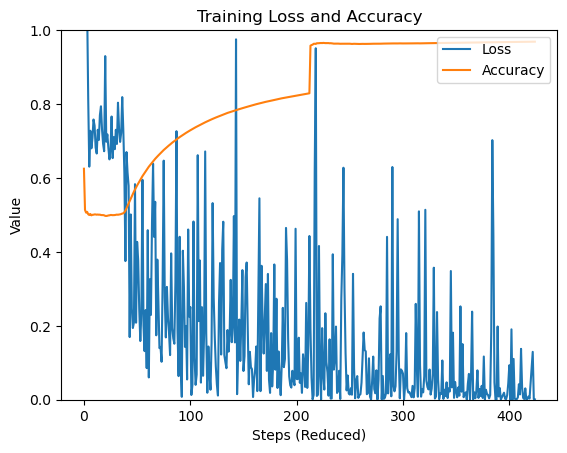

In [30]:
# Plotting Training accuracy and loss with varying learning rates and reduced number of steps

los = results[0]
los = [los[i] for i in range(0, len(los), 100)]
acc = results[2]
acc = [acc[i] for i in range(0, len(acc), 100)]
plt.ylim(0, 1)
plt.plot(list(range(len(los))), los) 
plt.plot(list(range(len(acc))), acc)
plt.title('Training Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Steps (Reduced)')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

In [25]:
# Evaluation after fine tuning

correct = 0
for sample in tqdm(dataset):
    result = prompt.apply(sample)
    context = result[0] + "Answer: [MASK]"
    probs = cond_log_prob(context, choices)
    pred = torch.argmax(probs).item()+1
    correct += pred == sample['label']

print(correct / len(dataset))

  0%|          | 0/1532 [00:00<?, ?it/s]

0.7336814621409922
